# CNN Posion Attack and Defense

#### Imports and Dependencies

In [1]:
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import nn
import os
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from tqdm import tqdm

from helper import print_accuracy

from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data.sampler import SubsetRandomSampler  #for validation test

%run clustering.ipynb

#### Setup the Device

In [2]:
# Check that MPS is available, if not, check if CUDA is available, if not, CPU
device = torch.device('cpu')
display_devices = False

if not torch.backends.mps.is_available():
    # If cuda is available...
    if torch.cuda.is_available():
        # Find GPU with most free memory and set that as the device
        mem_usage_list = [torch.cuda.mem_get_info(f'cuda:{gpu_num}')[0] for gpu_num in range(torch.cuda.device_count())]
        most_free = mem_usage_list.index(max(mem_usage_list))
        device = torch.device(f'cuda:{most_free}')
        print(f'Setting the device to {device}...\n')

        if display_devices:
            # Print GPU info on all
            for gpu_num in range(torch.cuda.device_count()):
                available_mem, total_mem = torch.cuda.mem_get_info(f'cuda:{gpu_num}')
                print(f'cuda:{gpu_num}')
                print('Memory Usage:')
                print('Total:', round(total_mem/1024**3,2), 'GB')
                print('Allocated:', round((total_mem-available_mem)/1024**3,2), 'GB')
                print('Free:   ', round(available_mem/1024**3,2), 'GB')
                print()
        # Set the default tensor type to gpu
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("mps")

Setting the device to cuda:1...



#### Constants

In [3]:
WORKING_DIR = os.getcwd()
MODELS_PATH = os.path.join(WORKING_DIR, "models")
FEATURES_PATH = os.path.join(WORKING_DIR, "features")

# Check if the models directory exists, if not, create it
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)

#### Load the Datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, generator=torch.Generator(device))

### Models

In [5]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=6, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features= 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features= 60, out_features = 10)

    def forward(self, tensor):
        # hidden layer 1
        tensor = self.conv1(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride= 2)
        # hidden layer 2
        tensor = self.conv2(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride = 2)
        # hidden layer 3
        tensor = tensor.reshape(-1, 12 * 4* 4)
        tensor = self.fc1(tensor)
        tensor = F.relu(tensor)
        # hidden layer 4
        tensor = self.fc2(tensor)
        tensor = F.relu(tensor)
        # output layer
        tensor = self.out(tensor)
        return tensor


class EmsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = models

    def forward(self, tensor):
        results = [model(tensor) for model in self.models]
        results = torch.stack(results)
        results = torch.mean(results, dim=0)
        return results

### Code to Train the Model

In [6]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs, model_path, retrain = False):
    train_losses, valid_losses = [], []
    predictions_list, labels_list = [], []

    # Load the model if retrain is False
    if not retrain:
        if os.path.exists(model_path):
            print(f"Loading model from {model_path}...")
            model.load_state_dict(torch.load(model_path))
            return
    # Otherwise, train the model
    print("Training model...")
    for e in range(epochs):
        # Set the model to training mode
        model.train()
        train_loss = 0
        # Iterate over the training data
        for images, labels in tqdm(train_loader):
            # Move the data to the device
            images, labels = images.to(device), labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)
            # Backward pass
            if torch.cuda.is_available():
                with torch.cuda.amp.autocast():
                    loss.backward()
            else:
                loss.backward()
            # Update the weights
            optimizer.step()
            train_loss += loss.item()
        else:
            # Set the model to evaluation mode
            model.eval()
            valid_loss, correct = 0, 0
            total = 0
            # Iterate over the validation data
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    valid_loss += criterion(output, labels).item()
                    correct += torch.sum(torch.argmax(output, dim=1) == labels).item()
                    total += len(labels)
            accuracy = correct / total
            # Save the model if the validation loss is the lowest so far
            print(f"Epoch: {e+1}/{epochs}  Training loss: {train_loss/len(train_loader):.4f}  Validation loss: {valid_loss/len(valid_loader):.4f}  Validation accuracy: {accuracy:.4f}")
            torch.save(model.state_dict(), model_path)

----
----

## Base Model

In [7]:
base_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(base_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(base_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [8]:
# Train the model
train_model(base_cnn_model, trainloader, validloader, optimizer, criterion, 10, os.path.join(MODELS_PATH, 'base_model.pt'))
# Print the accuracy of the model
print_accuracy(base_cnn_model, testloader, device)

Loading model from /home/jovyan/DL/DLProject/models/base_model.pt...
Accuracy of T-shirt/Top: 81.40%
Accuracy of Trouser: 96.70%
Accuracy of Pullover: 77.90%
Accuracy of Dress: 91.20%
Accuracy of Coat: 83.20%
Accuracy of Sandal: 93.70%
Accuracy of Shirt: 65.00%
Accuracy of Sneaker: 97.50%
Accuracy of Bag: 96.80%
Accuracy of Ankle Boot: 95.00%


----

## Training with Poisoned Attack

- knowledge-oblivious–the attacker shall have no knowledge of the target model’s parameters/structures, nor the original training datasets, 

- cleanlabel–the attacker shall not be able to control the labeling process, and

- clean-test–test-time instances shall not be required to be modified using added adversarial perturbations for attacking effectiveness (https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123720137.pdf)

In [9]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""

    def __init__(self, X, Y, transform = None):
        """Method to initilaize variables."""
        self.images = X
        self.labels = Y
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [10]:
def create_poison_dataset(x_train, y_train, size_of_infected):
    # generate the infected random indices from the training sample
    generatePoisonIdx = np.random.choice(len(x_train), size=(size_of_infected,), replace=False)
    # generate normal indices excluding from the training sample
    trainIdx = np.array([i for i in range(len(x_train)) if i not in generatePoisonIdx])

    # indexing all the infected
    x_pois_train, y_pois_train = x_train[generatePoisonIdx], y_train[generatePoisonIdx]
    # indexing all the noromal
    x_train_new, y_train_new = x_train[trainIdx], y_train[trainIdx]

    # mix up the labels(infecting the infected)
    random_labels = np.random.randint(10, size=size_of_infected)
    y_pois_train = np.where(y_pois_train == y_pois_train, random_labels, y_pois_train)

    x_poison_train = np.concatenate((x_train_new, x_pois_train))
    y_poison_train = np.concatenate((y_train_new, y_pois_train))

    print("Training samples after infection : ", x_poison_train.shape)
    print("Labels samples after infection : ", y_poison_train.shape)

    return x_poison_train, y_poison_train

In [11]:
transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

x_poison_train, y_poison_train = create_poison_dataset(trainset.data, trainset.targets, 20000)

dataset = FashionDataset(x_poison_train, y_poison_train, transform_new)

# Preparing for validaion test
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# to get 20% of the train set
split = int(np.floor(0.2 * len(dataset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
poisoned_trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
poisoned_validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 12, shuffle = True, generator=torch.Generator(device))

Training samples after infection :  (60000, 28, 28)
Labels samples after infection :  (60000,)


In [12]:
poisoned_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(poisoned_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(poisoned_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [13]:
# Train the model
train_model(
    poisoned_cnn_model, poisoned_trainloader, poisoned_validloader,
    optimizer, criterion, 10,
    os.path.join(MODELS_PATH, 'poisoned_model.pt')
)
# Print the accuracy of the model
print_accuracy(poisoned_cnn_model, testloader, device)

Loading model from /home/jovyan/DL/DLProject/models/poisoned_model.pt...
Accuracy of T-shirt/Top: 77.10%
Accuracy of Trouser: 95.50%
Accuracy of Pullover: 80.00%
Accuracy of Dress: 91.00%
Accuracy of Coat: 71.60%
Accuracy of Sandal: 92.70%
Accuracy of Shirt: 59.80%
Accuracy of Sneaker: 96.70%
Accuracy of Bag: 95.20%
Accuracy of Ankle Boot: 94.00%


----
----

## Defenses

In [14]:
# For defense, we will not split the validation set
poisoned_full_trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, generator=torch.Generator(device))

### Clustering
Using Auto Encoders to cluster the poisoned data and find the labels/accuracy improvement.

In [23]:
%run clustering.ipynb

##### Clustering with Flattening
Simply flattening before clustering.

Loading flattened data from saved location...
Clustering the data...


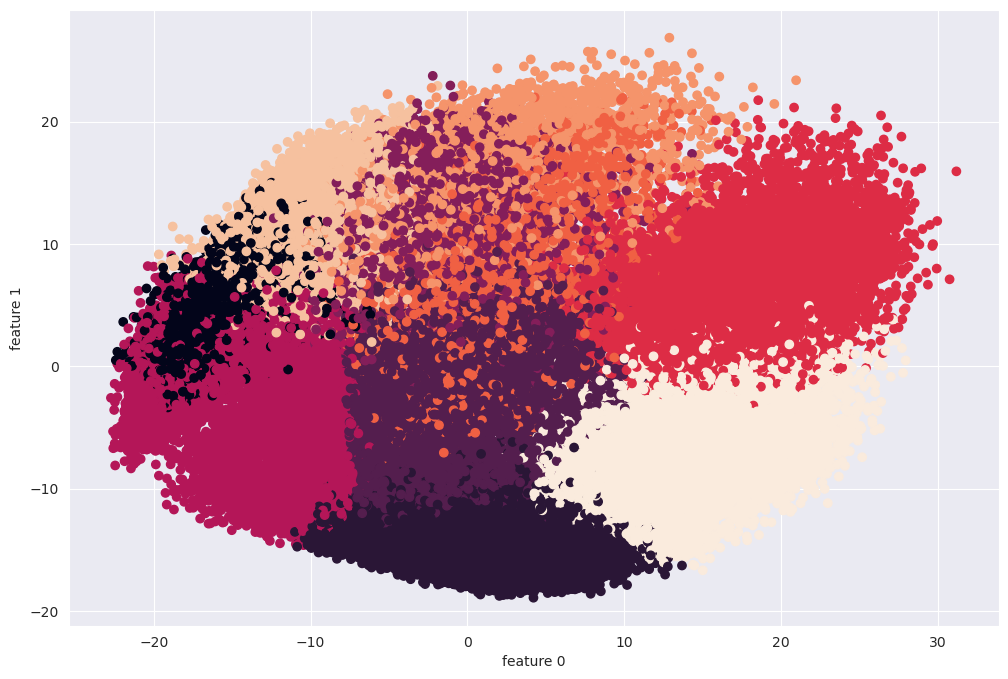

Clustering Accuracy PCA - Flatten Image (Train): 0.34901666666666664
Clustering Accuracy PCA - Flatten Image (Test): 0.4838

Loading flattened data from saved location...
Clustering the data...


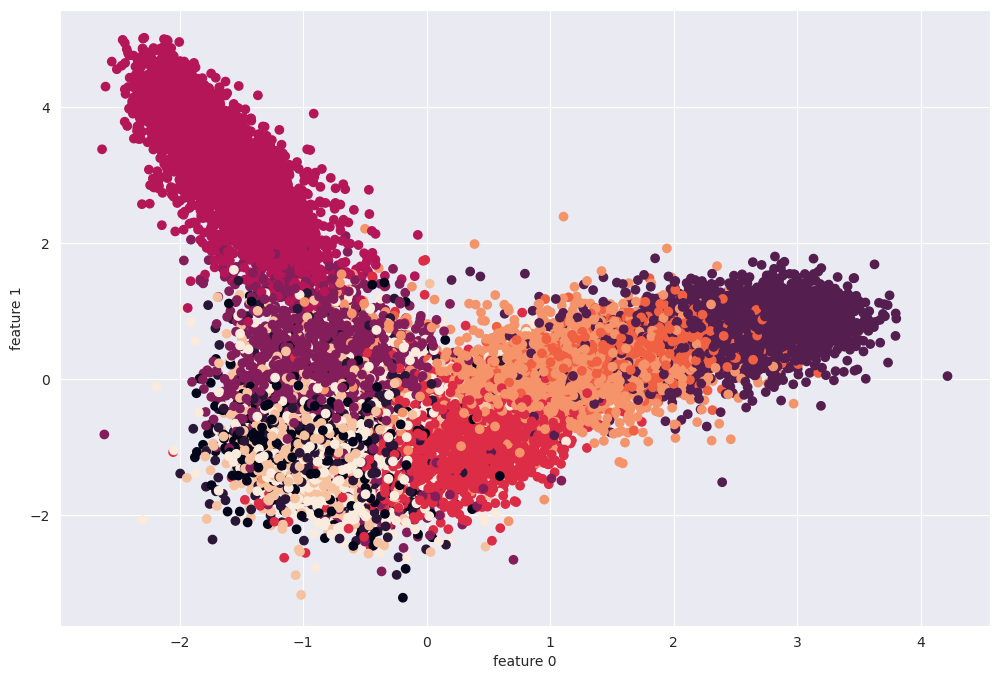

Clustering Accuracy LDA - Flatten Image (Train): 0.58365
Clustering Accuracy LDA - Flatten Image (Test): 0.8013


In [24]:
cae_flat_pca, train_flat_benchmark_pca, test_flat_benchmark_pca = train_cluster(poisoned_full_trainloader, testloader, "flat", "pca", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Flatten Image (Train): {train_flat_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Flatten Image (Test): {test_flat_benchmark_pca[1]['clustering_accuracy']}")
print()
cae_flat_lda, train_flat_benchmark_lda, test_flat_benchmark_lda = train_cluster(poisoned_full_trainloader, testloader, "flat", "lda", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy LDA - Flatten Image (Train): {train_flat_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Flatten Image (Test): {test_flat_benchmark_lda[1]['clustering_accuracy']}")

##### Clustering with Feature Extraction
Use VGG16 to extract features from images before clustering.

Loading feature data from saved location...
Clustering the data...


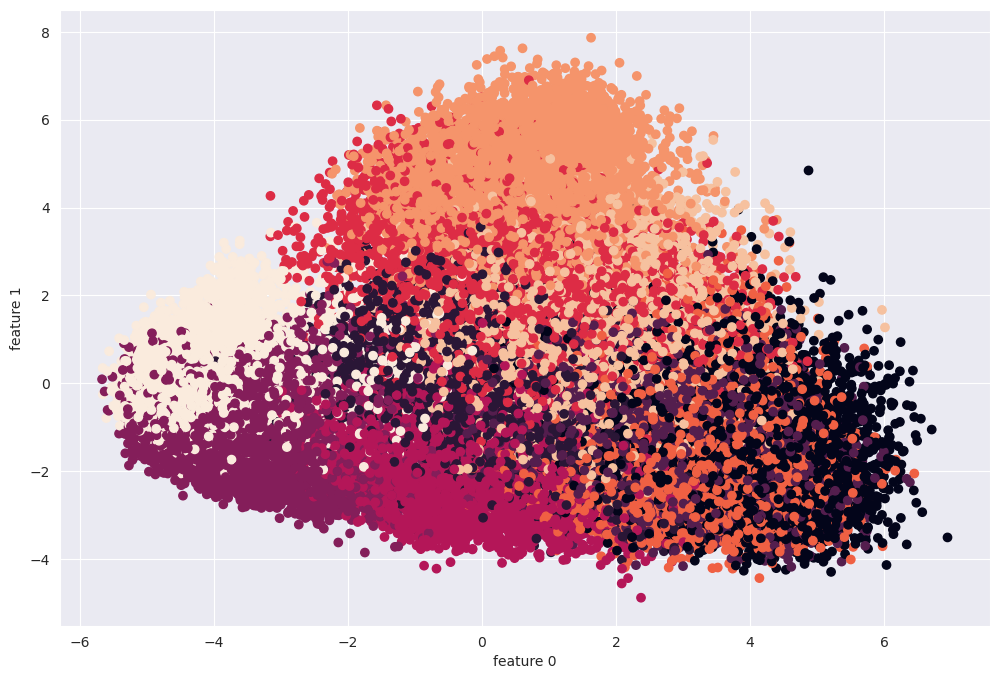

Clustering Accuracy PCA - Feature Image (Train): 0.39785
Clustering Accuracy PCA - Feature Image (Test): 0.5451

Loading feature data from saved location...
Clustering the data...


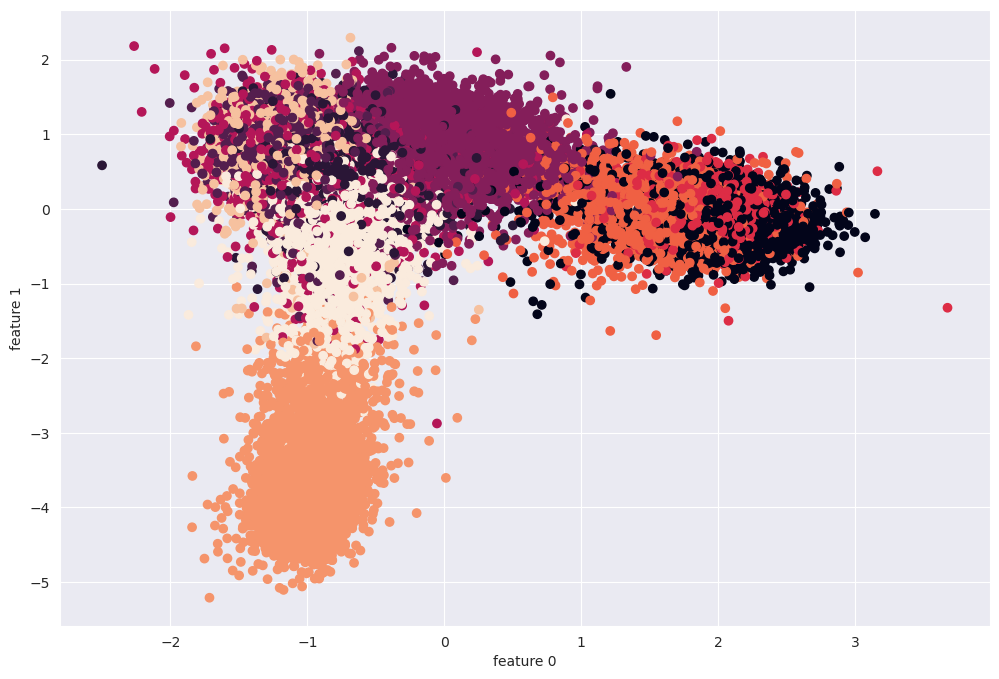

Clustering Accuracy LDA - Feature Image (Train): 0.5935666666666667
Clustering Accuracy LDA - Feature Image (Test): 0.8307


In [25]:
cae_feature_pca, train_feature_benchmark_pca, test_feature_benchmark_pca = train_cluster(poisoned_full_trainloader, testloader, "feature", "pca", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Feature Image (Train): {train_feature_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Feature Image (Test): {test_feature_benchmark_pca[1]['clustering_accuracy']}")
print()
cae_feature_lda, train_feature_benchmark_lda, test_feature_benchmark_lda = train_cluster(poisoned_full_trainloader, testloader, "feature", "lda", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy LDA - Feature Image (Train): {train_feature_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Feature Image (Test): {test_feature_benchmark_lda[1]['clustering_accuracy']}")

### Emsemble Learning
Using multiple smaller models to train on the poisoned dataset. The mean accuracy of the models can represent the true accuracy.